### Data Loading / Library

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
import itertools
from sklearn.decomposition import PCA
from gensim.models import Word2Vec
from gensim import models
from gensim.models import KeyedVectors
#!pip3 install jpype1==0.7.0
#!pip3 install konlpy

from IPython.display import clear_output
clear_output()

from konlpy.tag import Okt
from konlpy.utils import pprint
okt = Okt()

pd.set_option('display.max_rows', 20)

TypeError: argument should be integer or bytes-like object, not 'str'

In [ ]:
song_data_path = ""
model_path = ""
#------
song_data = pd.read_pickle(song_data_path)

playid = song_data['playid']
play = song_data['play']
genrechart = song_data['genrechart']

vec_playid = pd.read_pickle("")
vec_play = pd.read_pickle("")
vec_genrechart = pd.read_pickle("")

NameError: name 'pd' is not defined

### Input - 일기에 태깅

part 1 : Solar api 사용하여 일기 태깅 진행

---



In [ ]:
# ! pip install openai
# ! pip install python-dotenv

import os
from openai import OpenAI
from dotenv import load_dotenv
from google.colab import userdata
import ast

# API
def get_api():
    OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
    return OPENAI_API_KEY

api = get_api()
client = OpenAI(api_key = api)

# Keywords
def get_keywords(input_text):

    prompt = f"""
    You are a helpful asssistant.
    Extract **three emotions** and **three keyword** in **Korean** from the following text : {input_text}.
    Make sure all the answers are **nouns**.
    Follow the given format :
    {["emotion1", "emotion2", "emotion3", "keyword1", "keyword2", "keyword3"]}
    """

    response = client.chat.completions.create(
        model = "gpt-3.5-turbo",
        messages = [
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ],
        # max_tokens = 50,
        # temperature = 0.3
    )

    keywords = response.choices[0].message.content
    return keywords

#####################
input_text = """
드디어 한 학기가 끝나고 종강이야! 시험도 과제도 전부 끝나서 완전 후련하고 뿌듯해.
어제는 여행도 다녀왔구, 편안하고 몽글몽글한 시간들이었어.
오늘은 크리스마스 이브라서, 연말이 왔다는 거에 설레고 두근두근해!!
"""
#####################

keywords = get_keywords(input_text)
diary_tag = ast.literal_eval(keywords)
print(diary_tag) # ['후련', '뿌듯', '설레', '학기', '시험', '연말']

### Playlist - 태그 리스트 벡터화

#### part 1 : 데이터 불러오기 / 각 태그의 유사 단어 검색 / 유사단어 포함하여 벡터화

---

실행 후 전체 프로세스 시간 단축을 위해 pickle 파일로 저장

In [ ]:
##### 데이터 불러오기 #####
playid['tag'] = playid['tag'].apply(lambda x: x.split(', '))

##### 모델 로드 (텍스트 형식) #####
fasttext = KeyedVectors.load_word2vec_format(
    model_path,
    binary=False,  # 텍스트 형식이므로 False
    encoding='utf-8',  # UTF-8 인코딩으로 로드
    unicode_errors='ignore'  # 디코딩 에러 무시
)

def get_cos_dst(v1, v2):
    return 1 - (np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))

##### 태그 통합 과정 #####
word = playid['tag'].to_list()
#all tags - 기존 데이터의 태그 통합
all_tags = list(itertools.chain.from_iterable(playid['tag']))
# 기존 태그 중복 삭제
all_tags = list(set(all_tags))

##### missing_key 처리 #####
target_words = all_tags.copy()
all_words = all_tags.copy() # all_words = 원래 태그 + 비슷한 단어 100개씩
missing_keys = []  # missing_keys = 키가 없는 단어

for word in target_words:
    if word in fasttext:
        sim_words = [x[0] for x in fasttext.most_similar(word, topn=100)]
        all_words += sim_words
    else:
        missing_keys.append(word)

# all_words_org = all words의 사본
all_words_org = all_words.copy()

##### missing keys에 있는 단어들을 all_words와 taget_words에서 제거 #####

all_words = [i for i in all_words if i not in missing_keys]
target_words = [i for i in target_words if i not in missing_keys]

# 중복 태그 삭제
all_words = list(set(all_words))
target_words = list(set(target_words))

##### 단어 벡터화 : 각 단어 300차원 벡터화 #####
word_vecs = np.array([fasttext.get_vector(w) for w in all_words])
print(word_vecs.shape)


c:\Users\13wog\AppData\Local\Programs\Python\Python312\Lib\site-packages\gensim\models\keyedvectors.py:849: RuntimeWarning: invalid value encountered in divide
  dists = dot(self.vectors[clip_start:clip_end], mean) / self.norms[clip_start:clip_end]


(56360, 300)


c:\Users\13wog\AppData\Local\Programs\Python\Python312\Lib\site-packages\gensim\models\keyedvectors.py:849: RuntimeWarning: invalid value encountered in divide
  dists = dot(self.vectors[clip_start:clip_end], mean) / self.norms[clip_start:clip_end]


[]


In [ ]:
# 피클 저장
vector_playid = {'all_words': all_words, 'target_words': target_words,'word_vecs':word_vecs}
with open('vec_playid.pkl', 'wb') as f:
    pickle.dump(vector_playid, f)

#### part (1-2) : 벡터 리스트 PCA / 유사도 계산  

---
이하 부분은 실행하지 않음. 과정만 나타낸 것. 새로운 입력 후 새로 계산할 필요 있음.


In [ ]:
##### PCA #####
pca_3d = PCA(n_components=3)
comps = pca_3d.fit_transform(word_vecs)
df_comps = pd.DataFrame(comps,
                        columns=['comp_1', 'comp_2', 'comp_3'],
                        index=all_words)

###### matrix : 기존 태그와의 matching matrix. 태그가 존재하면 1, 아니면 0 #####
matrix = np.array([
    [(1 if tag in tags else 0) for tag in target_words]
    for tags in playid['tag']
])
matrix_df = pd.DataFrame(matrix, columns=target_words, index= playid['name'])

##### 리스트 벡터화 (df_doc_trans_pos) : 태그 리스트의 벡터화
df_targets = df_comps.loc[target_words]
df_doc_trans_pos = matrix_df.dot(df_targets)

##### 태그 리스트 간 유사도 행렬 계산 #####

# `df_doc_trans_pos`의 값을 NumPy 배열로 변환
vectors = df_doc_trans_pos.loc[playid['name']].values

# 벡터 간의 거리 행렬 계산 (유클리드 거리)
similarity_matrix = cosine_similarity(vectors)

# 거리 행렬을 데이터프레임으로 변환
similarity_df = pd.DataFrame(similarity_matrix, index=playid['name'], columns=playid['name'])

#### part 2 : PCA 분석

---
주성분이 설명하는 분산 비율에 대해 1) 90%이상 설명하는 차원 수 2) Elbow 그래프가 꺾이는 지점 두 가지를 동시 사용


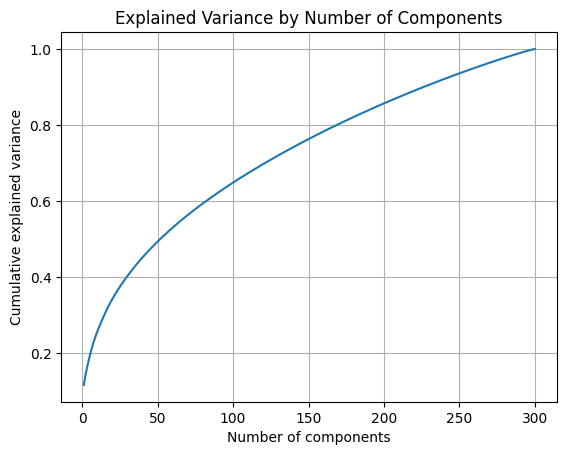

90% 이상의 분산을 설명하는 최소 차원 수: 227


In [ ]:
# PCA 수행
pca = PCA()
pca.fit(word_vecs)

# 각 주성분이 설명하는 분산 비율 확인
explained_variance_ratio = pca.explained_variance_ratio_

# 누적 분산 비율 계산
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# 그래프 시각화
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_explained_variance)
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("Explained Variance by Number of Components")
plt.grid(True)
plt.show()

# 분산 설명 비율이 90% 이상을 설명하는 최소 차원 수 찾기
optimal_components = np.argmax(cumulative_explained_variance >= 0.90) + 1
print(f"90% 이상의 분산을 설명하는 최소 차원 수: {optimal_components}")


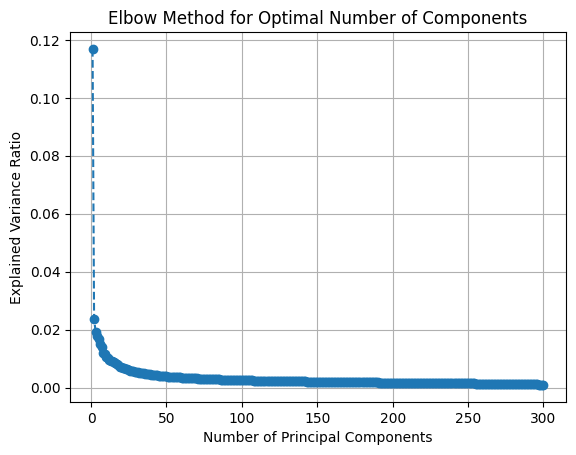

In [ ]:
# PCA 수행
pca = PCA()
pca.fit(word_vecs)

# 각 주성분이 설명하는 분산 비율 확인
explained_variance_ratio = pca.explained_variance_ratio_

# 분산 설명 비율을 사용하여 엘보우 그래프 그리기
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Elbow Method for Optimal Number of Components')
plt.grid(True)
plt.show()

# Elbow Method - 시각적으로 분산 설명 비율이 급격하게 감소하는 지점 찾기


#### part 3 : 새로 입력된 태그의 벡터화 / PCA / 유사도 계산 / 유사 아이템 찾기




In [ ]:
# 단어 벡터 불러오기
all_words = vec_playid['all_words']
target_words = vec_playid['target_words']
word_vecs = vec_playid['word_vecs']

# 새로운 입력
new_word_list = diary_tag

# 유사 단어 추가
new_all_words = new_word_list.copy()
new_target_words = new_word_list.copy()
new_missing_keys = []

# 새로 들어오는 태그에 대해 가장 비슷한 단어 20개 찾기
for word in new_word_list:
    if word in fasttext:
        sim_words = [x[0] for x in fasttext.most_similar(word, topn=20)]
        new_all_words += sim_words
    else:
        new_missing_keys.append(word)

# 유사 단어를 추가하고, 기존의 태그 리스트에 없는 단어만 필터링
new_all_words = [i for i in new_all_words if i not in new_missing_keys]
new_target_words = [i for i in new_target_words if i not in new_missing_keys]
new_all_words = list(set(new_all_words))
new_target_words = list(set(new_target_words))

# 기존 태그 pool에 없는 단어만 추가하여 word list 수정
new_all_words = [i for i in new_all_words if i not in all_words]
new_target_words = [i for i in new_target_words if i not in all_words]

# 새로운 단어 벡터화 및 기존 벡터와 결합
if new_all_words:  # new_all_words에 새로운 단어가 있을 경우
    new_word_vecs = np.array([fasttext.get_vector(w) for w in new_all_words])
    new_vecs_300 = np.concatenate((word_vecs, new_word_vecs), axis=0)  # 기존 벡터에 새로 추가된 벡터 합침
else:
    new_vecs_300 = word_vecs.copy()

# 중복 제거 후 합친 단어 리스트
new_all_words2 = list(set(all_words + new_all_words))
new_target_words2 = list(set(target_words + new_target_words))

# PCA 차원 축소
new_pca_3d = PCA(n_components=30)
new_comps = new_pca_3d.fit_transform(new_vecs_300)  # PCA를 수행하여 벡터 차원 축소
new_df_comps = pd.DataFrame(new_comps,
                            columns=[f'comp_{i+1}' for i in range(30)],
                            index=new_all_words2)

# 새로운 태그 리스트에 대해 벡터화
new_matrix = np.array([
    [(1 if tag in tags else 0) for tag in new_target_words2]
    for tags in playid['tag'].tolist() + [new_word_list]
])
col = playid['name'].tolist() + ['new']
new_matrix_df = pd.DataFrame(new_matrix, columns=new_target_words2, index=col)

new_df_targets = new_df_comps.loc[new_target_words2]
new_df_doc_trans_pos = new_matrix_df.dot(new_df_targets)

# 태그 리스트 간 유사도 계산
new_vectors = new_df_doc_trans_pos.loc[col].values
new_similarity_matrix = cosine_similarity(new_vectors)
new_similarity_df = pd.DataFrame(new_similarity_matrix, index=col, columns=col)

# 유사도 top n item 찾기 함수
def find_top_n_similar_people(similarity_matrix, person_idx, top_n=3):
    similarity_scores = similarity_matrix[person_idx]
    most_similar_indices = np.argsort(similarity_scores)[1:top_n+1]
    return most_similar_indices, similarity_scores[most_similar_indices]

# 유사도 top n item 찾기
person_idx = len(new_similarity_df) - 1
top_n = 5
most_similar_indices, similarity_scores = find_top_n_similar_people(new_similarity_matrix, person_idx, top_n)

# 결과 출력
playid = playid.reset_index(drop=True)
selected_names = [playid['name'][idx] for idx in most_similar_indices]
filtered_playlist = play[play['플리'].isin(selected_names)]

# '플리' 변수의 값이 selected_names에 있는 값들만 필터링
filtered_play = play[play['플리'].isin(selected_names)]
filtered_play = filtered_play.drop_duplicates(subset = ['제목', '가수'])

#곡 태그 126 * 300 벡터화

all_new_word_vecs_play = []  # 모든 행에 대한 벡터들을 저장할 리스트

for idx, row in filtered_play.iterrows():
    # '키워드'와 '감정' 열에서 단어들을 가져옵니다.
    keyword_list_play = row['키워드']  # 키워드 리스트
    emotion_list_play = row['감정']    # 감정 리스트

    # 두 리스트를 합쳐서 새로운 단어 리스트를 만듭니다.
    all_words_for_row_play = keyword_list_play + emotion_list_play  # 길이가 6인 단어 리스트

    new_all_words_play = all_words_for_row_play.copy()  # 유사 단어들을 저장할 리스트
    new_missing_keys_play = []  # 유사 단어를 못 찾은 단어들

    # 각 단어에 대해 유사 단어를 20개씩 찾기
    for word in all_words_for_row_play:
        if word in fasttext:  # fasttext에 있는 단어만 처리
            sim_words_play = [x[0] for x in fasttext.most_similar(word, topn=20)]
            new_all_words_play += sim_words  # 유사 단어들 추가
        else:
            new_missing_keys_play.append(word)  # 유사 단어를 못 찾은 단어들

    # 유사 단어를 찾지 못한 단어를 제외한 새로운 단어 리스트를 생성
    new_all_words_play = [i for i in new_all_words_play if i not in new_missing_keys_play]

    # vec_play에서 해당 단어들의 벡터를 찾아서 126x300 행렬 만들기
    new_word_vecs_play = []

    for word in new_all_words_play:
        if word in vec_play['all_words']:
            word_idx_play = vec_play['all_words'].index(word)
            new_word_vecs_play.append(vec_play['word_vecs'][word_idx_play])
        else:
            # 유사 단어를 못 찾은 경우, 벡터화할 방법을 결정해야 함
            print(f"Word {word} not found in vec_play['all_words']")

    # new_word_vecs가 126개의 벡터를 담고 있어야 함
    new_word_vecs_matrix_play = np.array(new_word_vecs_play)  # 126 x 300 행렬
    all_new_word_vecs_play.append(new_word_vecs_matrix_play)  # 각 행에 대한 벡터를 저장

# all_new_word_vecs는 이제 filtered_play의 각 행에 대한 126x300 행렬들이 저장됨
# 이것을 새로운 열로 추가하거나 다른 작업을 진행할 수 있습니다.

# 예시로 각 행에 대한 벡터를 새로운 열로 추가
filtered_play['word_vecs'] = all_new_word_vecs_play



### Playlist, Chart, Genre - 가사태그 기반 곡 전체 벡터화

In [ ]:
play['tag'] = play['키워드'] + play['감정']
genrechart['tag'] = genrechart['키워드'] + genrechart['감정']

In [ ]:
##### 모델 로드 (텍스트 형식) #####
fasttext = KeyedVectors.load_word2vec_format(
    model_path,
    binary=False,  # 텍스트 형식이므로 False
    encoding='utf-8',  # UTF-8 인코딩으로 로드
    unicode_errors='ignore'  # 디코딩 에러 무시
)

def get_cos_dst(v1, v2):
    return 1 - (np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))

##### 태그 통합 과정 #####
word = play['tag'].to_list()
#all tags - 기존 데이터의 태그 통합
all_tags = list(itertools.chain.from_iterable(play['tag']))
# 기존 태그 중복 삭제
all_tags = list(set(all_tags))

##### missing value 1차 형태소 분석 / 업데이트 #####

def replace_missing_tags(tag_list):
    new_tags = []
    for tag in tag_list:
        if tag in fasttext:
            new_tags.append(tag)
        else:
            # 형태소 분석으로 분리
            nouns = okt.nouns(tag)
            new_tags.extend([noun for noun in nouns if noun in fasttext])
    return new_tags

##### tag 업데이트
play['tag'] = play['tag'].apply(replace_missing_tags)

##### missing_key 처리 #####
target_words = all_tags.copy()
all_words = all_tags.copy() # all_words = 원래 태그 + 비슷한 단어 100개씩
missing_keys = []  # missing_keys = 키가 없는 단어

for word in target_words:
    if word in fasttext:
        sim_words = [x[0] for x in fasttext.most_similar(word, topn=100)]
        all_words += sim_words
    else:
        missing_keys.append(word)

# all_words_org = all words의 사본
all_words_org = all_words.copy()

##### missing keys에 있는 단어들을 all_words와 taget_words에서 제거 #####

all_words = [i for i in all_words if i not in missing_keys]
target_words = [i for i in target_words if i not in missing_keys]

# 중복 태그 삭제
all_words = list(set(all_words))
target_words = list(set(target_words))

##### 단어 벡터화 : 각 단어 300차원 벡터화 #####
word_vecs = np.array([fasttext.get_vector(w) for w in all_words])
print(word_vecs.shape)


In [ ]:
# 1) 피클 저장
vector_play = {'all_words': all_words, 'target_words': target_words,'word_vecs':word_vecs}
with open('vec_play.pkl', 'wb') as f:
    pickle.dump(vector_play, f)

In [ ]:
# 2) 피클 저장
vector_genrechart = {'all_words': all_words, 'target_words': target_words,'word_vecs':word_vecs}
with open('vec_genrechart.pkl', 'wb') as f:
    pickle.dump(vector_genrechart, f)

### Chart, Genre - 취향 조건 필터링

Part 1 : 취향 입력 및 필터링

---

아래 이어지는 1차적인 필터링 이후 남은 곡들 중에서 태그 유사도를 계산할 것

In [ ]:
genrechart_df = song_data['genrechart']

# 발매년도 범위에 맞는 데이터프레임을 반환하는 함수
def get_release_year_range(user_input):
    # 옛날 노래가 좋으세요? 질문에 대한 사용자 응답을 처리
    if user_input == 'O':
        return genrechart_df[genrechart_df['발매년도'] < 2010]  # 2010년 미만
    elif user_input == 'X':
        return genrechart_df[genrechart_df['발매년도'] >= 2010]  # 2010년 이상
    else:
        print("잘못된 입력입니다. 'O' 또는 'X'로 답변해주세요.")
        return None


def filter_likes_by_genre_and_year(genre, ox_input, release_input):
    # 장르 필터링
    genre_df = genrechart_df[genrechart_df['장르'].str.contains(genre, case=False, na=False)]

    # 발매년도 범위 조건에 맞는 데이터프레임 필터링
    release_df = get_release_year_range(release_input)

    if release_df is not None:
        # 발매년도 조건을 만족하는 데이터만 필터링
        genre_df = genre_df[genre_df['발매년도'].isin(release_df['발매년도'])]

    # 장르 내에서 좋아요 수 상위 75% 이상과 미만 구분
    if not genre_df.empty:
        upper_75 = genre_df['좋아요 수'].quantile(0.75)  # 상위 75% 값 계산
        lower_25 = genre_df['좋아요 수'].quantile(0.25)  # 하위 25% 값 계산

        # OX 입력을 대소문자 구분 없이 처리
        ox_input = ox_input.lower()  # ox_input을 소문자로 변환

        if ox_input == 'o':
            # 좋아요 수가 상위 75% 이상인 데이터만 필터링
            genre_df = genre_df[genre_df['좋아요 수'] >= upper_75]
        elif ox_input == 'x':
            # 좋아요 수가 상위 75% 미만인 데이터만 필터링
            genre_df = genre_df[genre_df['좋아요 수'] < upper_75]
        else:
            print("잘못된 OX 입력입니다. O 또는 X만 입력해주세요.")
            return None

    # 필터링된 데이터프레임이 비어 있으면 None 반환
    if genre_df.empty:
        return None

    return genre_df

# 사용자 입력 받기
user_input_genre = input("나의 취향 장르는? (예: 힙합, 발라드 등): ")
ox_input = input("나는 홍대병이 있다? (O: 상위 75%, X: 하위 75% 이하): ")
release_input = input("나는 옛날 노래가 좋다? (O, X): ")

# 필터링된 데이터프레임 얻기
filtered_df = filter_likes_by_genre_and_year(user_input_genre, ox_input, release_input)

if filtered_df is not None and not filtered_df.empty:
    print(filtered_df)
else:
    print("조건에 맞는 데이터가 없습니다.")

genre_list = ["댄스", "힙합", "록", "발라드", "인디음악", "트로트", "포크", "R&B", "일렉트로니카", "POP", "컨트리", "재즈"]


vec_genrechart = pd.read_pickle('C:/KIM/KUBIG/vector_chartgenre.pkl')

all_new_word_vecs_genrechart = []  # 모든 행에 대한 벡터들을 저장할 리스트

for idx, row in filtered_df.iterrows():
    # '키워드'와 '감정' 열에서 단어들을 가져옵니다.
    keyword_list_genrechart = row['키워드']  # 키워드 리스트
    emotion_list_genrechart = row['감정']    # 감정 리스트

    # 두 리스트를 합쳐서 새로운 단어 리스트를 만듭니다.
    all_words_for_row_genrechart = keyword_list_genrechart + emotion_list_genrechart  # 길이가 6인 단어 리스트

    new_all_words_genrechart = all_words_for_row_genrechart.copy()  # 유사 단어들을 저장할 리스트
    new_missing_keys_genrechart = []  # 유사 단어를 못 찾은 단어들

    # 각 단어에 대해 유사 단어를 20개씩 찾기
    for word in all_words_for_row_genrechart:
        if word in fasttext:  # fasttext에 있는 단어만 처리
            sim_words_genrechart = [x[0] for x in fasttext.most_similar(word, topn=20)]
            new_all_words_genrechart += sim_words  # 유사 단어들 추가
        else:
            new_missing_keys_genrechart.append(word)  # 유사 단어를 못 찾은 단어들

    # 유사 단어를 찾지 못한 단어를 제외한 새로운 단어 리스트를 생성
    new_all_words_genrechart = [i for i in new_all_words_genrechart if i not in new_missing_keys_genrechart]

    # vec_play에서 해당 단어들의 벡터를 찾아서 126x300 행렬 만들기
    new_word_vecs_genrechart = []

    for word in new_all_words_genrechart:
        if word in vec_genrechart['all_words']:
            word_idx_genrechart = vec_genrechart['all_words'].index(word)
            new_word_vecs_genrechart.append(vec_genrechart['word_vecs'][word_idx_genrechart])
        else:
            # 유사 단어를 못 찾은 경우, 벡터화할 방법을 결정해야 함
            print(f"Word {word} not found in vec_play['all_words']")

    # new_word_vecs가 126개의 벡터를 담고 있어야 함
    new_word_vecs_matrix_genrechart = np.array(new_word_vecs_genrechart)  # 126 x 300 행렬
    all_new_word_vecs_genrechart.append(new_word_vecs_matrix_genrechart)  # 각 행에 대한 벡터를 저장

# all_new_word_vecs는 이제 filtered_play의 각 행에 대한 126x300 행렬들이 저장됨
# 이것을 새로운 열로 추가하거나 다른 작업을 진행할 수 있습니다.

# 예시로 각 행에 대한 벡터를 새로운 열로 추가
filtered_df['word_vecs'] = all_new_word_vecs_genrechart




### Playlist, Chart, Genre - 필터링 후 곡 유사도 계산

1. 유사 3~5개 플레이리스트 검색 후 플레이리스트 안 곡들 play 데이터에서 찾기
2. genrechart 데이터에서 필터링된 곡들을 1번 곡들과 합치기 => 후보곡
3. 후보곡들의 벡터 찾아서 데이터 프레임 만들기 (vec_play, vec_genrechart 사용)
4. PCA / 유사도 계산 및 순서 출력

In [ ]:
##플리 곡들과 장르, 차트 곡들 합치기

# 필요한 열만 추출 (장르, 제목, 가수, 가사)
filtered_df_selected = filtered_df[['장르', '제목', '가수', '가사', 'word_vecs']]
filtered_play_selected = filtered_play[['장르', '제목', '가수', '가사', 'word_vecs']]

# 두 데이터프레임을 세로로 합치기 (행 단위)
final_df = pd.concat([filtered_df_selected, filtered_play_selected], axis=0, ignore_index=True)

#중복제거
final_df = final_df.drop_duplicates(subset = ['제목', '가수'], keep='first')

#입력태그 300차원 벡터화
final_word_vec = np.array([fasttext.get_vector(w) for w in new_word_list])

##### 실제 결과 출력
def compute_euclidean_distance(vec1, vec2):
    return np.linalg.norm(vec1 - vec2)

# final_word_vec (3, 300)을 각 행에 맞게 벡터화하고, 각 행과 유클리드 거리 계산

distances = []

# final_df에서 각 행의 word_vec을 가져와서 final_word_vec과 비교
for idx, row in final_df.iterrows():
    word_vec = row['word_vecs']  # (300,) 형태
    # final_word_vec을 (3, 300) -> (300,) 형태로 바꿔서 비교
    for i in range(final_word_vec.shape[0]):  # final_word_vec.shape[0] = 3
        distance = compute_euclidean_distance(word_vec, final_word_vec[i])
        distances.append((idx, distance))

# distances는 [(index, distance), ...] 형태로 결과가 저장됨
# 유사도가 가장 높은 행 10개를 추출
distances_sorted = sorted(distances, key=lambda x: x[1])  # 거리 기준으로 오름차순 정렬
distances_sorted_df = pd.DataFrame(distances_sorted, columns=['index', 'distance'])
distances_sorted_df = distances_sorted_df.drop_duplicates(subset=['index'])


# 가장 가까운 10개의 행을 선택
top_10_similar = distances_sorted_df.head(10)
top_10_indices = top_10_similar['index']

# top_10_indices를 이용하여 final_df에서 해당 행을 추출
top_10_rows = final_df.iloc[top_10_indices]

# 결과 확인
print(top_10_rows)